As an artificial (not very realistic and simplified) example, we consider two buildings: A and B which both have two rooms, respectively (A1, A2, B1 and B2). A is poorly insulated, while B is good insulated. Both buildings are heated using supply water from a common boiler, with hot water first led through building A and then through building B. Since the supply temperature drops along the pipe, the heating efficiency decreases. We assume only two sources that affect the indoor temperature $y_t$ at discretized time step $t \in \{0, \ldots, N\}$: the outdoor temperature $x_t$ and the power of the boiler $p_t$. In this example, we will always have $p_t=1$, why we will be omitted in following equations. The (discretized) dynamics of the indoor temperature for room $r \in \{1,2\}$ and building $b \in \{A,B\}$ is
$$y_{t,b,r} = y_{t - 1, b, r} + x_{t} k_{b} + m_{b,r} + \epsilon.$$
Hence, $k_b$ denotes the degree of insulation and $m_{b,r}$ denotes the heating efficiency. The noise is distributed as  $\epsilon \sim \mathcal{N}(0,0.001)$, and the (true) parameter values we will use are
$$4k_{A}=1,\ k_{B}=0.4,\ m_{A,1}=1,\ m_{A,2}=0.9,\ m_{B,1}=0.5,\ m_{B,2}=0.4.$$
The outdoor temperature is generated as
$$x_t = \cos(2\pi t/N) - 1.$$
We start by creating the data frame:

In [29]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

rng = default_rng(100)

N = 30

heating_power = np.repeat(1, N)
outdoor_temperature = np.cos(np.linspace(0, 2 * np.pi, N)) - 1
time = np.arange(N)

df = pd.DataFrame({'building': np.repeat(['a', 'b'], 2 * N),
                   'room': np.repeat(['a1', 'a2', 'b1', 'b2'], N),
                   'time': np.tile(time, 4),
                   'heating_power': np.tile(heating_power, 4),
                   'outdoor_temperature': np.tile(outdoor_temperature, 4),
                   'indoor_temperature': 20
                   })
noise_std = 1e-3
df.loc[df['room'] == 'a1', 'indoor_temperature'] += (
        heating_power * 1 + outdoor_temperature * 1 + rng.normal(0, noise_std, N)).cumsum()
df.loc[df['room'] == 'a2', 'indoor_temperature'] += (
        heating_power * .9 + outdoor_temperature * 1 + rng.normal(0, noise_std, N)).cumsum()
df.loc[df['room'] == 'b1', 'indoor_temperature'] += (
        heating_power * .5 + outdoor_temperature * .4 + rng.normal(0, noise_std, N)).cumsum()
df.loc[df['room'] == 'b2', 'indoor_temperature'] += (
        heating_power * .4 + outdoor_temperature * .4 + rng.normal(0, noise_std, N)).cumsum()

Let's visualize the simulated temperatures:

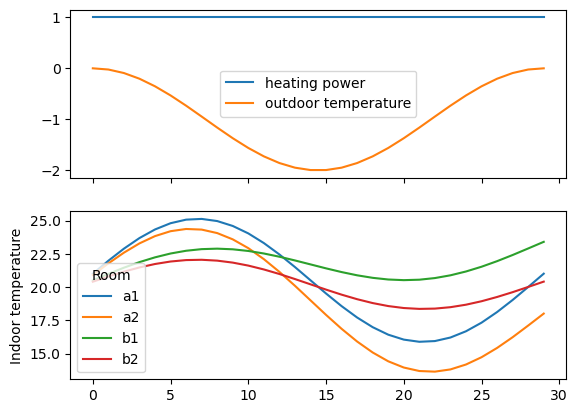

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True)
axes[0].plot(heating_power, label='heating power')
axes[0].plot(outdoor_temperature, label='outdoor temperature')
axes[0].legend()

for room in ['a1', 'a2', 'b1', 'b2']:
    axes[1].plot(time, df.loc[df['room'] == room, 'indoor_temperature'], label=room)
axes[1].legend(title='Room')
axes[1].set_ylabel('Indoor temperature')
plt.show()

We will consider regression problem of one time step ahead, meaning the linear regression data looks like this:

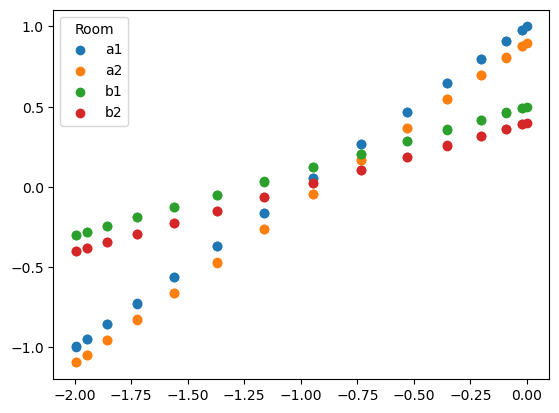

In [31]:
import matplotlib.pyplot as plt

df['y'] = df.groupby('room')['indoor_temperature'].diff()
df = df.dropna()

for k, g in df.groupby('room'):
    plt.scatter(g['outdoor_temperature'], g['y'], label=k)
plt.legend(title='Room')
plt.show()

Now, we define our hierarchical model. Suppose we know there is a variation in the degree of insulation for different buildings, why a one-level hierarchy should be applicable for the slope. For the heating power, rooms in the same buildings may vary slightly, and variation between different buildings is even larger. Therefore, we assume a two-level hierarchy for the intercept. The (prior) model we assume is then:
\
$K_{b} \sim \mathcal{N}(\mu_{\text{k}}, \sigma_{\text{k}}),\ \mu_{\text{k}} \sim \mathcal{N}(0, 1),\ \sigma_{\text{k}} \sim Exp(1000)$
\
$M_{b, r} \sim \mathcal{N}(\mu_{\text{m}, b}, \sigma_{\text{m}}),\ \mu_{\text{m}, b} \sim \mathcal{N}(\mu_{\text{m, global}}, \sigma_{\text{m, global}}),\ \sigma_{\text{m}} \sim Exp(1000)$
\
$\mu_{\text{k, global}} \sim \mathcal{N}(0,1),\ \sigma_{\text{k, global}} \sim Exp(10)$
\
Due to the Gaussian noise, we also use a Gaussian likelihood:
\
$Y_{t,b,r} - Y_{t - 1, b, r} = x_{t-1} K_{b} + M_{b,r} + \mathcal{N}(0, \sigma_{\text{err}}),\ \sigma_{\text{err}} \sim Exp(1000)$

Formulating and doing inference from this model is done by

In [32]:
import pymc as pm
from sakkara.model import HierarchicalVariable as HV, Likelihood, DataContainer, VariableContainer, HierarchicalModel

coeff = HV(pm.Normal,
           name='outdoor_temperature',
           group='building',
           mu=HV(
               pm.Normal
           ),
           sigma=HV(
               pm.Exponential,
               lam=1000
           )
           )
intercept = HV(pm.Normal,
               name='heating_power',
               group='room',
               mu=HV(
                   pm.Normal,
                   group='building',
                   mu=HV(
                       pm.Normal
                   ),
                   sigma=HV(
                       pm.Exponential,
                       lam=10
                   )
               ),
               sigma=HV(
                   pm.Exponential,
                   lam=1000
               )
               )

data = DataContainer(df)
coeffs = VariableContainer([coeff])

likelihood = Likelihood(pm.Normal, mu=(coeffs * data).sum() + intercept, sigma=HV(pm.Exponential, lam=1000),
                        data=data['y'])
model = HierarchicalModel(df, likelihood)

with model.build():
    idata = pm.sample(chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_outdoor_temperature, sigma_outdoor_temperature, outdoor_temperature, mu_mu_heating_power, sigma_mu_heating_power, mu_heating_power, sigma_heating_power, heating_power, sigma_likelihood]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 73 seconds.


We can see that true parameters can be recovered quite well:

In [33]:
import arviz as az

summary = az.summary(idata)
print(summary.loc[:, 'mean'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mu_outdoor_temperature       0.700
outdoor_temperature[a]       1.000
outdoor_temperature[b]       0.400
mu_mu_heating_power          0.672
mu_heating_power[a]          0.949
mu_heating_power[b]          0.451
heating_power[a1]            1.000
heating_power[a2]            0.900
heating_power[b1]            0.500
heating_power[b2]            0.400
sigma_outdoor_temperature    0.057
sigma_mu_heating_power       0.262
sigma_heating_power          0.022
sigma_likelihood             0.001
Name: mean, dtype: float64


Also by inspecting the trace below, we see a relatively quite small confidence in most of the marginal posteriors for each variable. However, a good exercise is to tweak the priors, and/or the noise in the data, and see how it is reflected in the posterior.

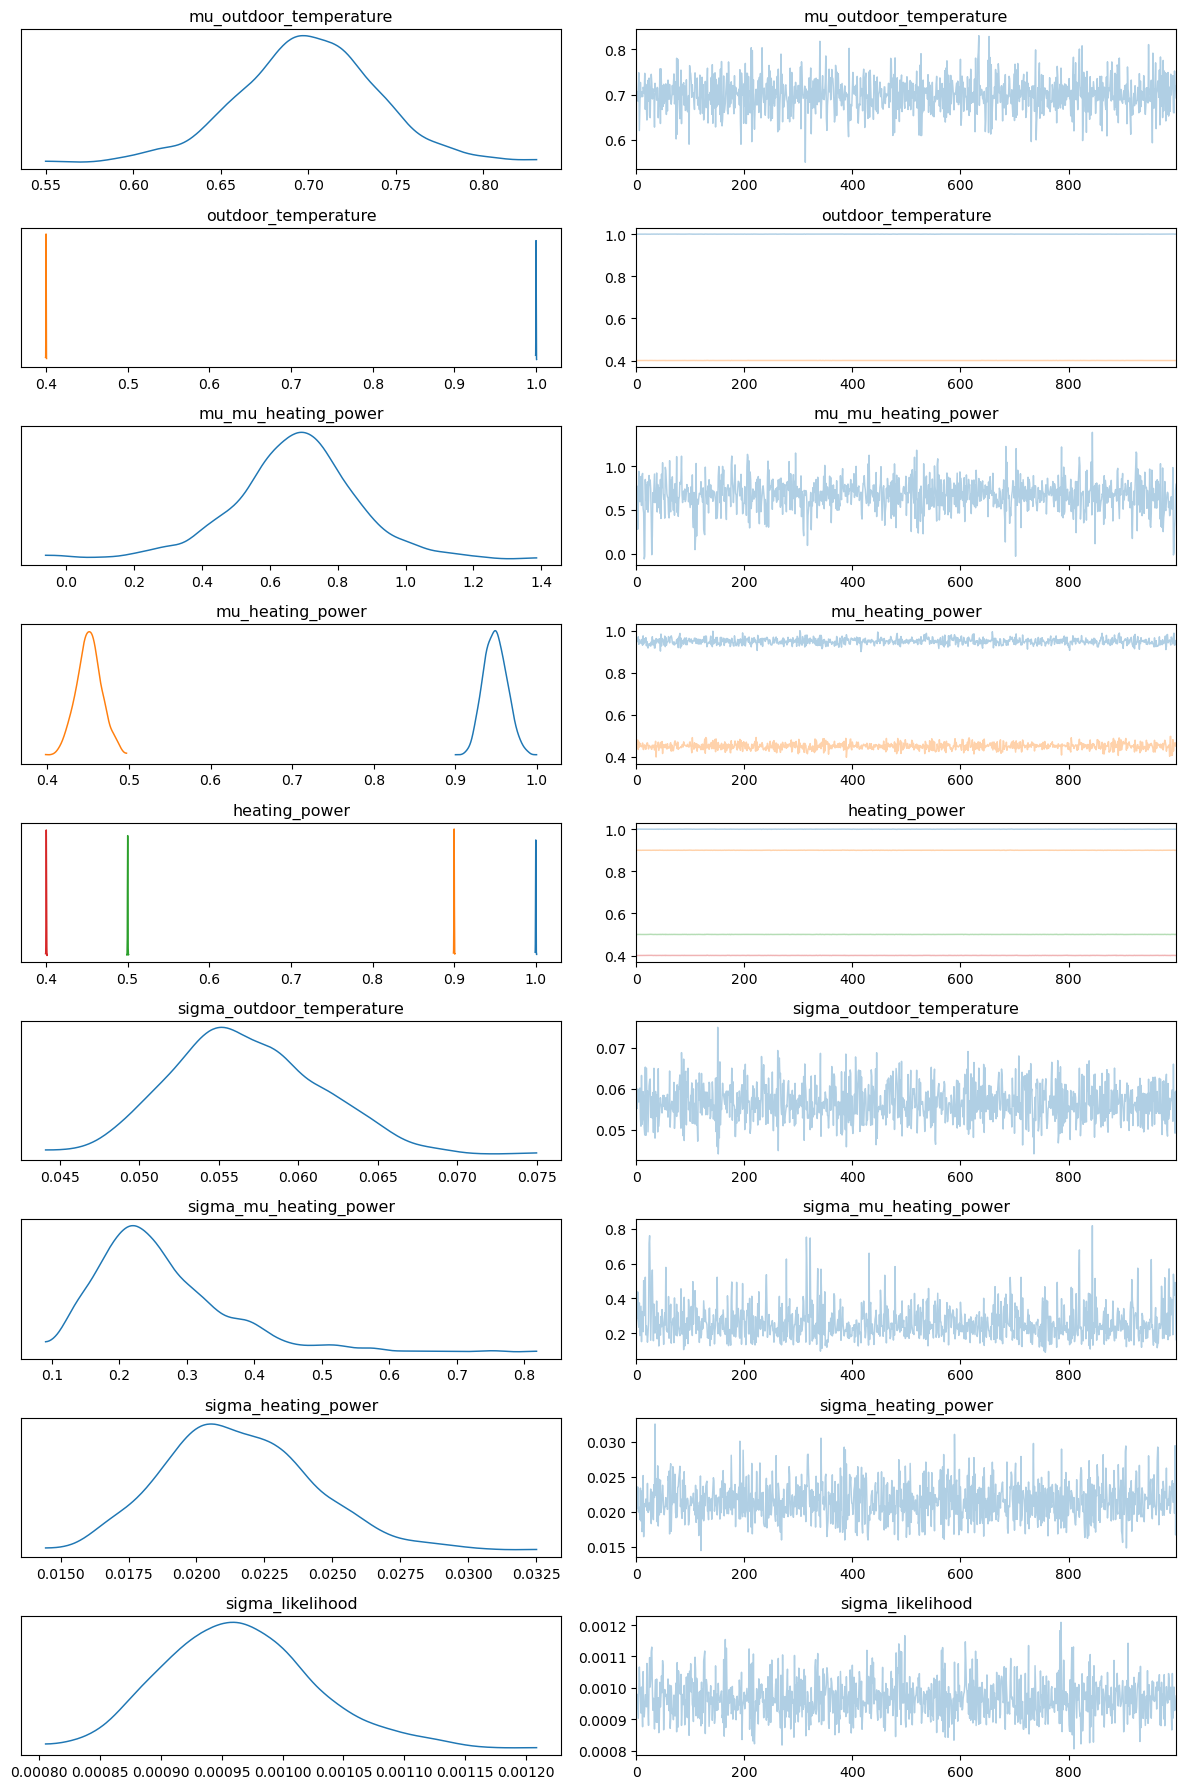

In [34]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()